# Exploratory Data Analysis  
Kaggle Competition Distracted Drivers  
Take a look at example images, attempt to reduce dimensions using PCA.

In [25]:
# imports
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
from sklearn.decomposition import RandomizedPCA as PCA
from time import time

# for plotting in jupyter
%matplotlib inline 

# constants
TRAIN_DIR = './imgs/train/'

In [3]:
class_dir = [os.path.join(TRAIN_DIR, d) for d in os.listdir(TRAIN_DIR)]

Visualize the distribution of image samples for each class

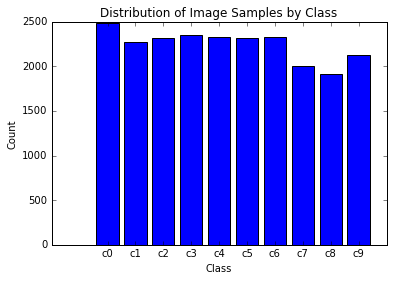

In [4]:
n_imgs = [len(os.listdir(class_dir[i])) for i in range(len(class_dir))]
plt.bar(range(len(class_dir)), n_imgs, tick_label=os.listdir(TRAIN_DIR), align='center')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Image Samples by Class')
plt.show()

## PCA  
1. First, get a representative sample from each class to train PCA. 
2. Process the images by resizing and converting to grayscale.
3. Apply PCA  
4. Visualize comparison of images to PCA

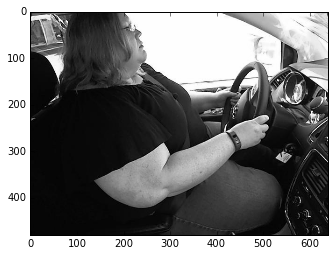

In [14]:
# set random seed for replicability
np.random.seed(3142)

# Take 10% of each images from each class
SAMPLE_PROPORTION = 0.1
sample_sizes = [int(SAMPLE_PROPORTION * n_imgs[i]) for i in range(len(n_imgs))]

# Randomly choose images (paths) from each class proportional to their distribution in the training set
sample_img_paths = []
for i in range(len(class_dir)):
    class_img_paths = [os.path.join(class_dir[i], f) for f in os.listdir(class_dir[i])]
    sample_img_paths.append(list(np.random.choice(class_img_paths, size=sample_sizes[i], replace=False)))
sample_img_paths = np.concatenate(sample_img_paths)

# Show an example image
img = cv2.imread(sample_img_paths[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

In [19]:
# get aspect ratio
n_samples = len(sample_img_paths)
img_sizes = np.zeros((n_samples, 3))
for i in range(n_samples):
    img = cv2.imread(sample_img_paths[i])
    img_sizes[i] = np.array(img.shape)
    
med_shape = np.mean(img_sizes, axis=0)
print med_shape

[ 480.  640.    3.]


It appears that all of the imgages are RGB of size 640x480. This size is likely larger than necessary for good performance, so we will reduce the dimensions to 100 x (100*480/640), and convert to grayscale before applying PCA.

2237 images processed in 49.521 seconds


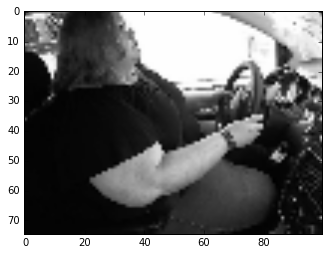

In [28]:
NEW_WIDTH = 100
new_dim = (NEW_WIDTH, int(NEW_WIDTH * 480./640))

# each image will be represented as a flattened vector of pixel intensities
imgs = np.zeros((n_samples, np.prod(new_dim)))

t0 = time()
for i in range(n_samples):
    img = cv2.imread(sample_img_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(img, new_dim)
    imgs[i] = resized.reshape(np.prod(new_dim))
    
print '{} images processed in {sec:.{rd}f} seconds'.format(n_samples, sec=time()-t0, rd=3)

# show example resized image
plt.imshow(imgs[0].reshape((new_dim[1], new_dim[0])), cmap='gray')

In [30]:
N_COMPONENTS = 200 #must be specified for approximate SVD
SEED = 3142

t0 = time()
pca = PCA(n_components=N_COMPONENTS, whiten=True, random_state=SEED)
pca.fit(imgs)
print '{} components fit in {sec:.{rd}f} seconds'.format(N_COMPONENTS, sec=time()-t0, rd=3)

200 components fit in 1.79999995231628417968750 seconds


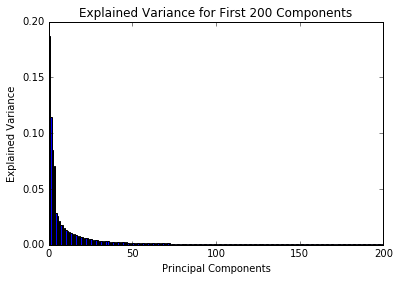

In [32]:
plt.bar(range(N_COMPONENTS), pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance for First {} Components'.format(N_COMPONENTS))

It appears that the first 4 principal components capture a majority of the variance.

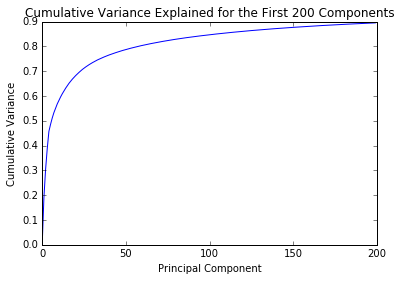

In [34]:
cum_var = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(N_COMPONENTS)]
plt.plot(range(N_COMPONENTS), cum_var)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance Explained for the First {} Components'.format(N_COMPONENTS))


In [44]:
FIRST_N = 23
var_explained = np.sum(pca.explained_variance_ratio_[:FIRST_N])
print '{0:.{1}f} variance explained by first {2} components'.format(var_explained, 3, FIRST_N)

0.701 variance explained by first 23 components


In [45]:
# refit with first N components
pca = PCA(n_components=FIRST_N, whiten=True, random_state=SEED)
pca.fit(imgs)

RandomizedPCA(copy=True, iterated_power=3, n_components=23, random_state=3142,
       whiten=True)

Get a sense for the PCA representation for a few images:

In [68]:
def plot_pca(x):
    dims = (new_dim[1], new_dim[0])
    raw = imgs[x].reshape(dims)
    transformed = pca.transform(imgs[x].reshape(1, -1))
    reconstructed = pca.inverse_transform(transformed).reshape(dims)
    
    f, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(raw, cmap='gray')
    ax1.set_title('Raw')
    ax2.imshow(reconstructed, cmap='gray')
    ax2.set_title('PCA Representation')
    plt.show()    

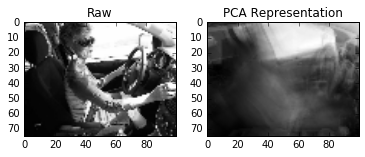

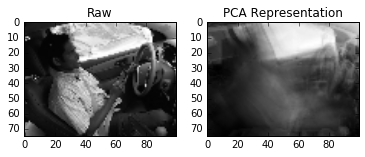

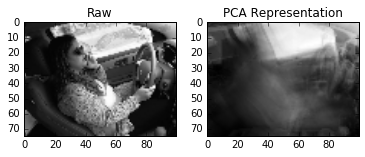

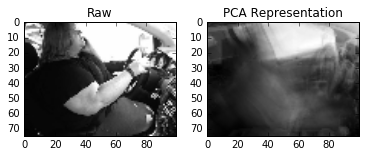

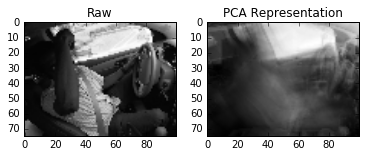

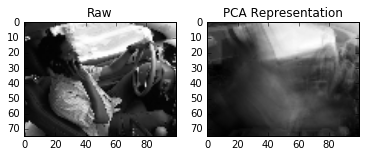

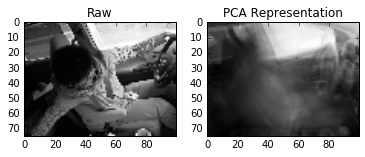

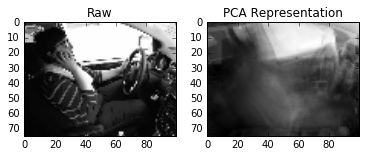

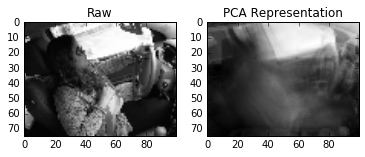

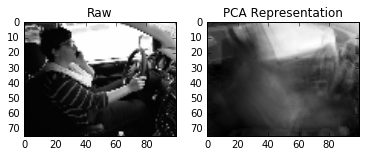

In [70]:
rand_imgs = np.random.choice(range(n_samples), 5)
for rand_img in rand_imgs:
    plot_pca(rand_img)

The reconstructed images don't look all that different. Perhaps more Components are needed for good differentiation. Let's try again with 200.  

In [74]:
pca = PCA(n_components=N_COMPONENTS, whiten=True, random_state=SEED)
pca.fit(imgs)
print '{v:.{rd}} Variance Explained by first {c} Components'.format(v=np.sum(pca.explained_variance_ratio_), rd=4, c=N_COMPONENTS)

0.8952 Variance Explained by first 200 Components


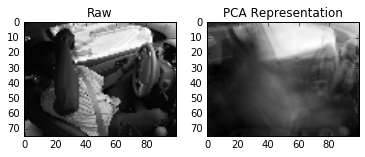

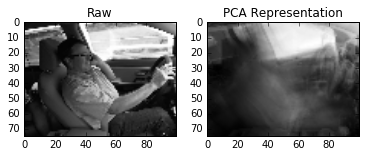

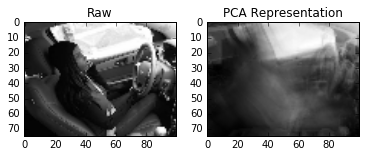

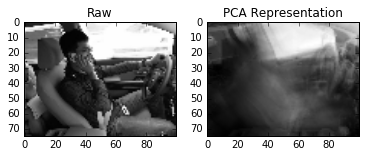

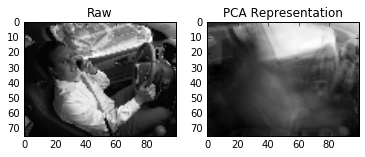

In [72]:
rand_imgs = np.random.choice(range(n_samples), 5)
for rand_img in rand_imgs:
    plot_pca(rand_img)

## Next Steps  
Try training classifiers using PCA.